In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [3]:
sentence = "Chihuahua is cute dog"

In [4]:
def tokenizer(sentence):
    vocabulary = sentence.split()
    vocabulary.append("<EOS>")
    
    return vocabulary

In [5]:
def vocabulary_one_hot_encoder(tokens):
    results = []

    for i, _ in enumerate(tokens):
        one_hot_encode_vector = [0. for i in range(len(tokens))]
        
        for j in range(i + 1):
            one_hot_encode_vector[j] = 1. if j == i else 0.

        results.append(one_hot_encode_vector)
                    
    return results

In [6]:
def create_cbow_pairs(sequence, window_size):
    cbow_pairs = []

    for i in range(len(sequence)):
        context = []

        for j in range(-window_size, window_size + 1):
            if i + j >= 0 and i + j < len(sequence) and j != 0:
                context.append(sequence[i + j])

        if context:
            context = np.sum(context, axis=0) / len(context)
            cbow_pairs.append(context)
            
    return cbow_pairs

In [7]:
def word_decoder(anwser_list, vocabulary):
    idx = anwser_list.index(max(anwser_list))        
    return vocabulary[idx]

In [8]:
tokens = tokenizer(sentence)
print(tokens)

['Chihuahua', 'is', 'cute', 'dog', '<EOS>']


In [9]:
training_x = vocabulary_one_hot_encoder(tokens)
print(training_x)

[[1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0]]


In [10]:
CONTEXT_SIZE = 2

training_y = create_cbow_pairs(training_x, CONTEXT_SIZE)
print(training_y)

[array([0. , 0.5, 0.5, 0. , 0. ]), array([0.33333333, 0.        , 0.33333333, 0.33333333, 0.        ]), array([0.25, 0.25, 0.  , 0.25, 0.25]), array([0.        , 0.33333333, 0.33333333, 0.        , 0.33333333]), array([0. , 0. , 0.5, 0.5, 0. ])]


In [11]:
class CBOWModeler(nn.Module):
    def __init__(self, volcabulary_size, embedding_dim):
        super(CBOWModeler, self).__init__()
        self.linear1 = nn.Linear(volcabulary_size, embedding_dim, bias=False)
        self.linear2 = nn.Linear(embedding_dim, volcabulary_size, bias=False)

    def forward(self, x):
        out = self.linear1(x)
        out = self.linear2(out)
        return F.softmax(out, dim=-1)
    
    def save_embedding_model(self):
        params = self.linear1.state_dict()
        torch.save(params, "./embedding_model.pt")

In [12]:
EMBEDDING_DIM = 2

losses = []
loss_function = nn.CrossEntropyLoss()
model = CBOWModeler(len(tokens), EMBEDDING_DIM).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

CBOWModeler(
  (linear1): Linear(in_features=5, out_features=2, bias=False)
  (linear2): Linear(in_features=2, out_features=5, bias=False)
)


In [13]:
for epoch in range(100):
    total_loss = 0
    
    for x, y in zip(training_x, training_y):
        x, y = torch.tensor(x).to(device), torch.tensor(y).to(device)

        model.zero_grad()

        y_hat = model(x)

        loss = loss_function(y, y_hat)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    losses.append(total_loss)

model.save_embedding_model()

In [14]:
import matplotlib.pyplot as plt

In [15]:
def plot_losses(ax, t, losses):
    ax.plot(t, losses)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")

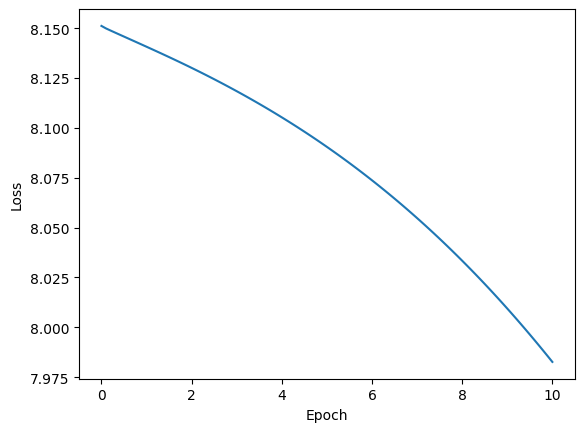

In [16]:
fig, ax = plt.subplots()
plot_losses(ax, np.linspace(0., 10., len(losses)), losses)

In [17]:
for x, y in zip(training_x, training_y):
    # Get predicted vector
    pred = model(torch.tensor(x).to(device))

    # Get the argmax index
    argmax_idx = torch.argmax(pred, keepdim=True)

    # Create a one-hot encoded tensor
    anwser_vector = F.one_hot(argmax_idx, num_classes=pred.size(-1)).int()
    anwser_list = anwser_vector.tolist()

    question = word_decoder(x, tokens)
    answer = word_decoder(anwser_list[0], tokens)
    print(question, answer)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat2 in method wrapper_CUDA_mm)